<a href="https://colab.research.google.com/github/MittalMonika/DataScience/blob/master/Yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **End-to-end document table extraction and summarization pipeline leveraging computer vision and natural language processing technique**

Below is brief outline of the steps that need to be executed for the workflow

1. Read document (pdf) from a given location.
2. Split the document into pages and covert each page into png/jpg format and save with appropriate naming convention
3. Use  trained&deployee YOLO model to mark table boundaries
4. Extract sub Images by cutting those tables out of original images.
5. Perform OCR on tables and extract the text matrix
6. Send the text to openai and generate a summary of the table.
---




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/yolov8

/content/drive/MyDrive/yolov8


# 1. Read document (pdf) from a given location

To read a document on goole colab
 that isIt is easy to upload document to google drive but To read a document that is not on Google Drive and we don't want to upload it manually each time we can use Google Colab following steps


*   Upload Directly to google drive and note the path where the document is uploaded : go to the folder and upload the document "/content/drive/MyDrive/yolov7/Pdf_document/AutomateDocument.pdf"
*   If is not on Google Drive and we don't want to upload it manually each time and its availabe as a online URL document (see below)



In [41]:
!pip install pytesseract
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,858 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [21]:
document_name = "AutomateDocument.pdf"
#constant_path = "/content/drive/MyDrive/yolov7/Table-Extraction-PDF-2/"
constant_path = "/content/drive/MyDrive/yolov8/Pdf_document/"
pdf_file = constant_path + document_name
outdir = document_name.replace(".pdf", "")
output_dir =constant_path + "Pdf_To_Images/" + outdir
output_dir_ = output_dir +"/"
inf_dir = output_dir_ + "detect/"

# the directory from which the weights are taken for inference
#model_dir = "/content/drive/MyDrive/yolov8/runs/detect/train4/weights/best.pt"
model_dir = "/content/drive/MyDrive/yolov8/runs/detect/yolo8_best.pt"
train_data ="/content/drive/MyDrive/yolov8/Table-Extraction-PDF-2"


In [52]:
os.mkdir("/content/drive/MyDrive/yolov8/Table-Extraction-PDF-2/Annotated")

In [ ]:
import requests

# Replace the URL with the link to your PDF document
pdf_url = "https://www.bls.gov/osmr/research-papers/2014/pdf/st140030.pdf"
headers = {
    "Referer": "https://www.bls.gov/osmr/research-papers/"
}
# Fetch the PDF content from the URL
response = requests.get(pdf_url, headers=headers)
# Check if the request was successful (status code 200)
if response.status_code == 403:
    # Access the PDF content as bytes
    pdf_content = response.content
    # To save the PDF content to a local file in Colab:
    with open("/content/drive/MyDrive/yolov7/Pdf_document/AutomateDocument.pdf", "wb") as pdf_file:
        pdf_file.write(pdf_content)
    #Open and manipulate the local file in Colab.
else:
    print("Failed to fetch the PDF document from the URL.")


# 2. Split the document into pages and covert each page into png/jpg format and save them with appropriate naming convention

*   For this we use package pdf2image and Poppler




In [10]:
!pip install pdf2image
# Install Poppler
!apt-get install poppler-utils

# Restart the runtime to apply changes (necessary for some installations)
#import os
#os.kill(os.getpid(), 9)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.2 [186 kB]
Fetched 186 kB in 0s (426 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 120875 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.2_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.2) ...
Setting up poppler-utils (22.02.0-2ubuntu0.2) ...
Processing triggers for man-db (2.10.2-1) ...


In [11]:
import os
from pdf2image import convert_from_path
# Specify the PDF file path
os.makedirs(output_dir, exist_ok=True)
#os.mkdir(output_dir)
# Convert PDF to a list of PNG images
images = convert_from_path(pdf_file)

# Save PNG images to files
for i, image in enumerate(images):
    image.save(os.path.join(output_dir, f"output_page_{i + 1}.png"), "PNG")
print("The images are saved in ", output_dir)

The images are saved in  /content/drive/MyDrive/yolov8/Pdf_document/Pdf_To_Images/AutomateDocument


## Training YOLOv8 on a Custom Dataset (identify Tables)

This notebook is based on the ultralytics package and performs training on own custom objects and here i am using a document set and trying to tag tables from the scanned/screenshot images


### **Steps that are followed**

To train the yolov8 follow steps:

* Install YOLOv8 and all its dependencies
* Load custom dataset here i took document-parts dataset
* Run YOLOv8 training
* Evaluate YOLOv8 performance
* Run YOLOv8 inference on test images

### Preparing a Custom Dataset

Annotating the dataset : As a important step we need to annotate the dataset. Yolov8 basically need a file which has a same name of the image and annotation text images_1.jpg images_1.txt. here images_1.txt conatins the co-ordinates of a bounding box basically defining our object to be tagged. There are some tools which we can use like LabelImg which basically will create a same textfile name  as of image but manually we need to draw one/multiple bounding to tag different parts that image conatins

Split dataset basically into train,test, validation folder

In this i am taking an open source computer vision dataset from [Roboflow Universe](https://universe.roboflow.com)

For future when we need our own images (and, optionally, annotations), we can convert your dataset using [Roboflow](https://roboflow.com), a set of tools use to build better computer vision models quickly and accurately. It say it can be used for (automatic) annotation, converting dataset formats (like to YOLOv7), training, deploying, and improving their datasets/models.


In [9]:
#recommended way of installing through pip
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 10.3 MB/s eta 0:00:00


In [12]:
#installing through source
#!git clone https://github.com/ultralytics/ultralytics
#!cd ultralytics
#!pip install -e ultralytics

#The New YOLOv8 API

The developers of YOLOv8 decided to break away from the standard YOLO project design : separate train.py, detect.py, val.py, and export.py scripts. In the short term it will probably cause some confusion while in the long term, it is a fantastic decision!

This pattern has been around since YOLOv3, and every YOLO iteration has replicated it. It was relatively simple to understand but notoriously challenging to deploy especially in real-time processing and tracking scenarios.

The new approach is much more flexible because it allows YOLOv8 to be used independently through the terminal, as well as being part of a complex computer vision application.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="E6SilmdsaEtYL1IDtIQc")
project = rf.workspace("mohamed-traore-2ekkp").project("table-extraction-pdf")
dataset = project.version(2).download("yolov8")


#Train YOLOv8 on a custom dataset


In [ ]:
!yolo task=detect \
mode=train \
model=yolov8m.pt \
data={train_data}/data.yaml \
epochs=20 \
imgsz=640

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/yolov8/Table-Extraction-PDF-2/data.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, fo

# Validate with a new model

When the training is over, we can validate the new model on images it has not seen before. Therefore, when creating a dataset, we divide it into three parts, and one of them that we will use now as a test dataset.

In [22]:
!yolo task=detect \
mode=val \
model= {model_dir} \
data= {train_data}/data.yaml

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/yolov8/Table-Extraction-PDF-2/valid/labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100% 70/70 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:29<00:00,  5.81s/it]
                   all         70        109      0.943      0.905      0.966      0.913
              bordered         70         23      0.991      0.913      0.981      0.971
            borderless         70         86      0.895      0.896       0.95      0.854
Speed: 6.5ms preprocess, 215.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val5
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
!ls /content/drive/MyDrive/yolov7/Pdf_document/Pdf_To_Images/AutomateDocument/output_page_5.png


detect	     detect3  output_page_1.png  output_page_4.png  output_page_7.png
detect2      detect4  output_page_2.png  output_page_5.png  output_page_8.png
detect2_new  detect5  output_page_3.png  output_page_6.png


In [25]:
!yolo task=detect \
mode=predict \
model={model_dir} \
conf=0.25 \
source={output_dir_} \
name={inf_dir} \
save_txt= True


Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

image 1/8 /content/drive/MyDrive/yolov8/Pdf_document/Pdf_To_Images/AutomateDocument/output_page_1.png: 640x512 (no detections), 197.6ms
image 2/8 /content/drive/MyDrive/yolov8/Pdf_document/Pdf_To_Images/AutomateDocument/output_page_2.png: 640x512 (no detections), 161.1ms
image 3/8 /content/drive/MyDrive/yolov8/Pdf_document/Pdf_To_Images/AutomateDocument/output_page_3.png: 640x512 (no detections), 153.7ms
image 4/8 /content/drive/MyDrive/yolov8/Pdf_document/Pdf_To_Images/AutomateDocument/output_page_4.png: 640x512 1 borderless, 158.4ms
image 5/8 /content/drive/MyDrive/yolov8/Pdf_document/Pdf_To_Images/AutomateDocument/output_page_5.png: 640x512 1 borderless, 156.1ms
image 6/8 /content/drive/MyDrive/yolov8/Pdf_document/Pdf_To_Images/AutomateDocument/output_page_6.png: 640x512 2 borderlesss, 157.2ms
image 7/8 /content/drive/My

# 4. Extract sub Images by cutting those tables out of original images.

In [47]:
import cv2
import os

# Define the directory containing the images and text files

image_directory = output_dir
text_directory = inf_dir + "labels/"
output_directory = inf_dir + "TagTable/"
margin =15


# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Loop through the image files in the directory
for image_filename in os.listdir(image_directory):
    if image_filename.endswith(".png"):  # Assuming your images are in JPEG format
        image_path = os.path.join(image_directory, image_filename)

        # Load the image
        img = cv2.imread(image_path)

        # Load the corresponding text file
        text_filename = os.path.splitext(image_filename)[0] + ".txt"
        text_path = os.path.join(text_directory, text_filename)

        # Check if the text file exists
        if os.path.exists(text_path):
            # Read and parse the YOLO annotations from the text file
            with open(text_path, "r") as file:
                lines = file.readlines()
                table_counter = 1  # Counter for naming tables
                for line in lines:
                    # Parse the YOLO annotation (class_id, x_center, y_center, width, height)
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())

                    # Convert YOLO coordinates to OpenCV coordinates
                    x1 = int((x_center - width / 2) * img.shape[1])
                    y1 = int((y_center - height / 2) * img.shape[0])
                    x2 = int((x_center + width / 2) * img.shape[1])
                    y2 = int((y_center + height / 2) * img.shape[0])

                    # Add a margin around the table
                    x1 -= margin
                    y1 -= margin
                    x2 += margin
                    y2 += margin


                    # Ensure the coordinates are within the image boundaries
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(img.shape[1], x2)
                    y2 = min(img.shape[0], y2)

                    # Crop the table from the image based on the coordinates
                    table = img[y1:y2, x1:x2]

                    # Generate a filename for the extracted table
                    table_filename = os.path.splitext(image_filename)[0] + f"_table_{table_counter}.jpg"
                    table_path = os.path.join(output_directory, table_filename)

                    # Save the extracted table as a new image
                    cv2.imwrite(table_path, table)

                    # Increment the table counter
                    table_counter += 1

# Optionally, you can add error handling, resizing, or other processing as needed


# 5. Perform OCR on tables and extract the text matrix

In [50]:
import cv2
import pytesseract
from PIL import Image

# Load the image with tables
image_directory = output_directory
# Output directory for saving OCR results
outputocr_directory = inf_dir + "OCRTable/"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)
#print(os.listdir(image_directory),image_directory)
# Loop through the image files in the directory
for image_filename in os.listdir(image_directory):
    if image_filename.endswith(".jpg"):  # Adjust the file extension as needed
        image_path = os.path.join(image_directory, image_filename)
        #print("image_path",image_path)
        image = cv2.imread(image_path)


        pil_image = Image.fromarray(image)

        # Convert the image to grayscale for better OCR accuracy
        #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Use pytesseract to perform OCR on the grayscale image
        #ocr_result = pytesseract.image_to_string(gray_image)
        ocr_result = pytesseract.image_to_string(image)

        # Split the OCR result into lines
        lines = ocr_result.split('\n')

        # Initialize an empty matrix to store the table data
        table_matrix = []

        # Iterate through the lines to extract and construct the matrix
        for line in lines:
            # Split each line by tab or space, depending on your table's formatting
            cells = line.split('\t')  # You can also try ' ' or other delimiters
            cleaned_cells = [cell.strip() for cell in cells if cell.strip()]  # Remove empty cells

            if cleaned_cells:
                table_matrix.append(cleaned_cells)
        # Convert the table matrix to a string
        table_str = "\n".join(["\t".join(row) for row in table_matrix])

        # Generate a filename for the OCR result text file
        output_filename = os.path.splitext(image_filename)[0] + "_ocr.txt"
        output_path = os.path.join(outputocr_directory, output_filename)

        # Save the OCR result to the text file
        with open(output_path, "w") as file:
            file.write(table_str)

print("OCR results saved in the directory:", outputocr_directory)


OCR results saved in the directory: /content/drive/MyDrive/yolov8/Pdf_document/Pdf_To_Images/AutomateDocument/detect/OCRTable/


# EXTRA CODE
### Draw annotations for train and test data or any other file you would like having your image and txt file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['output_page_1.png', 'output_page_2.png', 'output_page_3.png', 'output_page_4.png', 'output_page_5.png', 'output_page_6.png', 'output_page_7.png', 'output_page_8.png', 'detect']
total number of images in this directory is : 9
output_page_4.png 1 0.498138 0.767796 0.64572 0.087686

Name is:  0 output_page_4.png


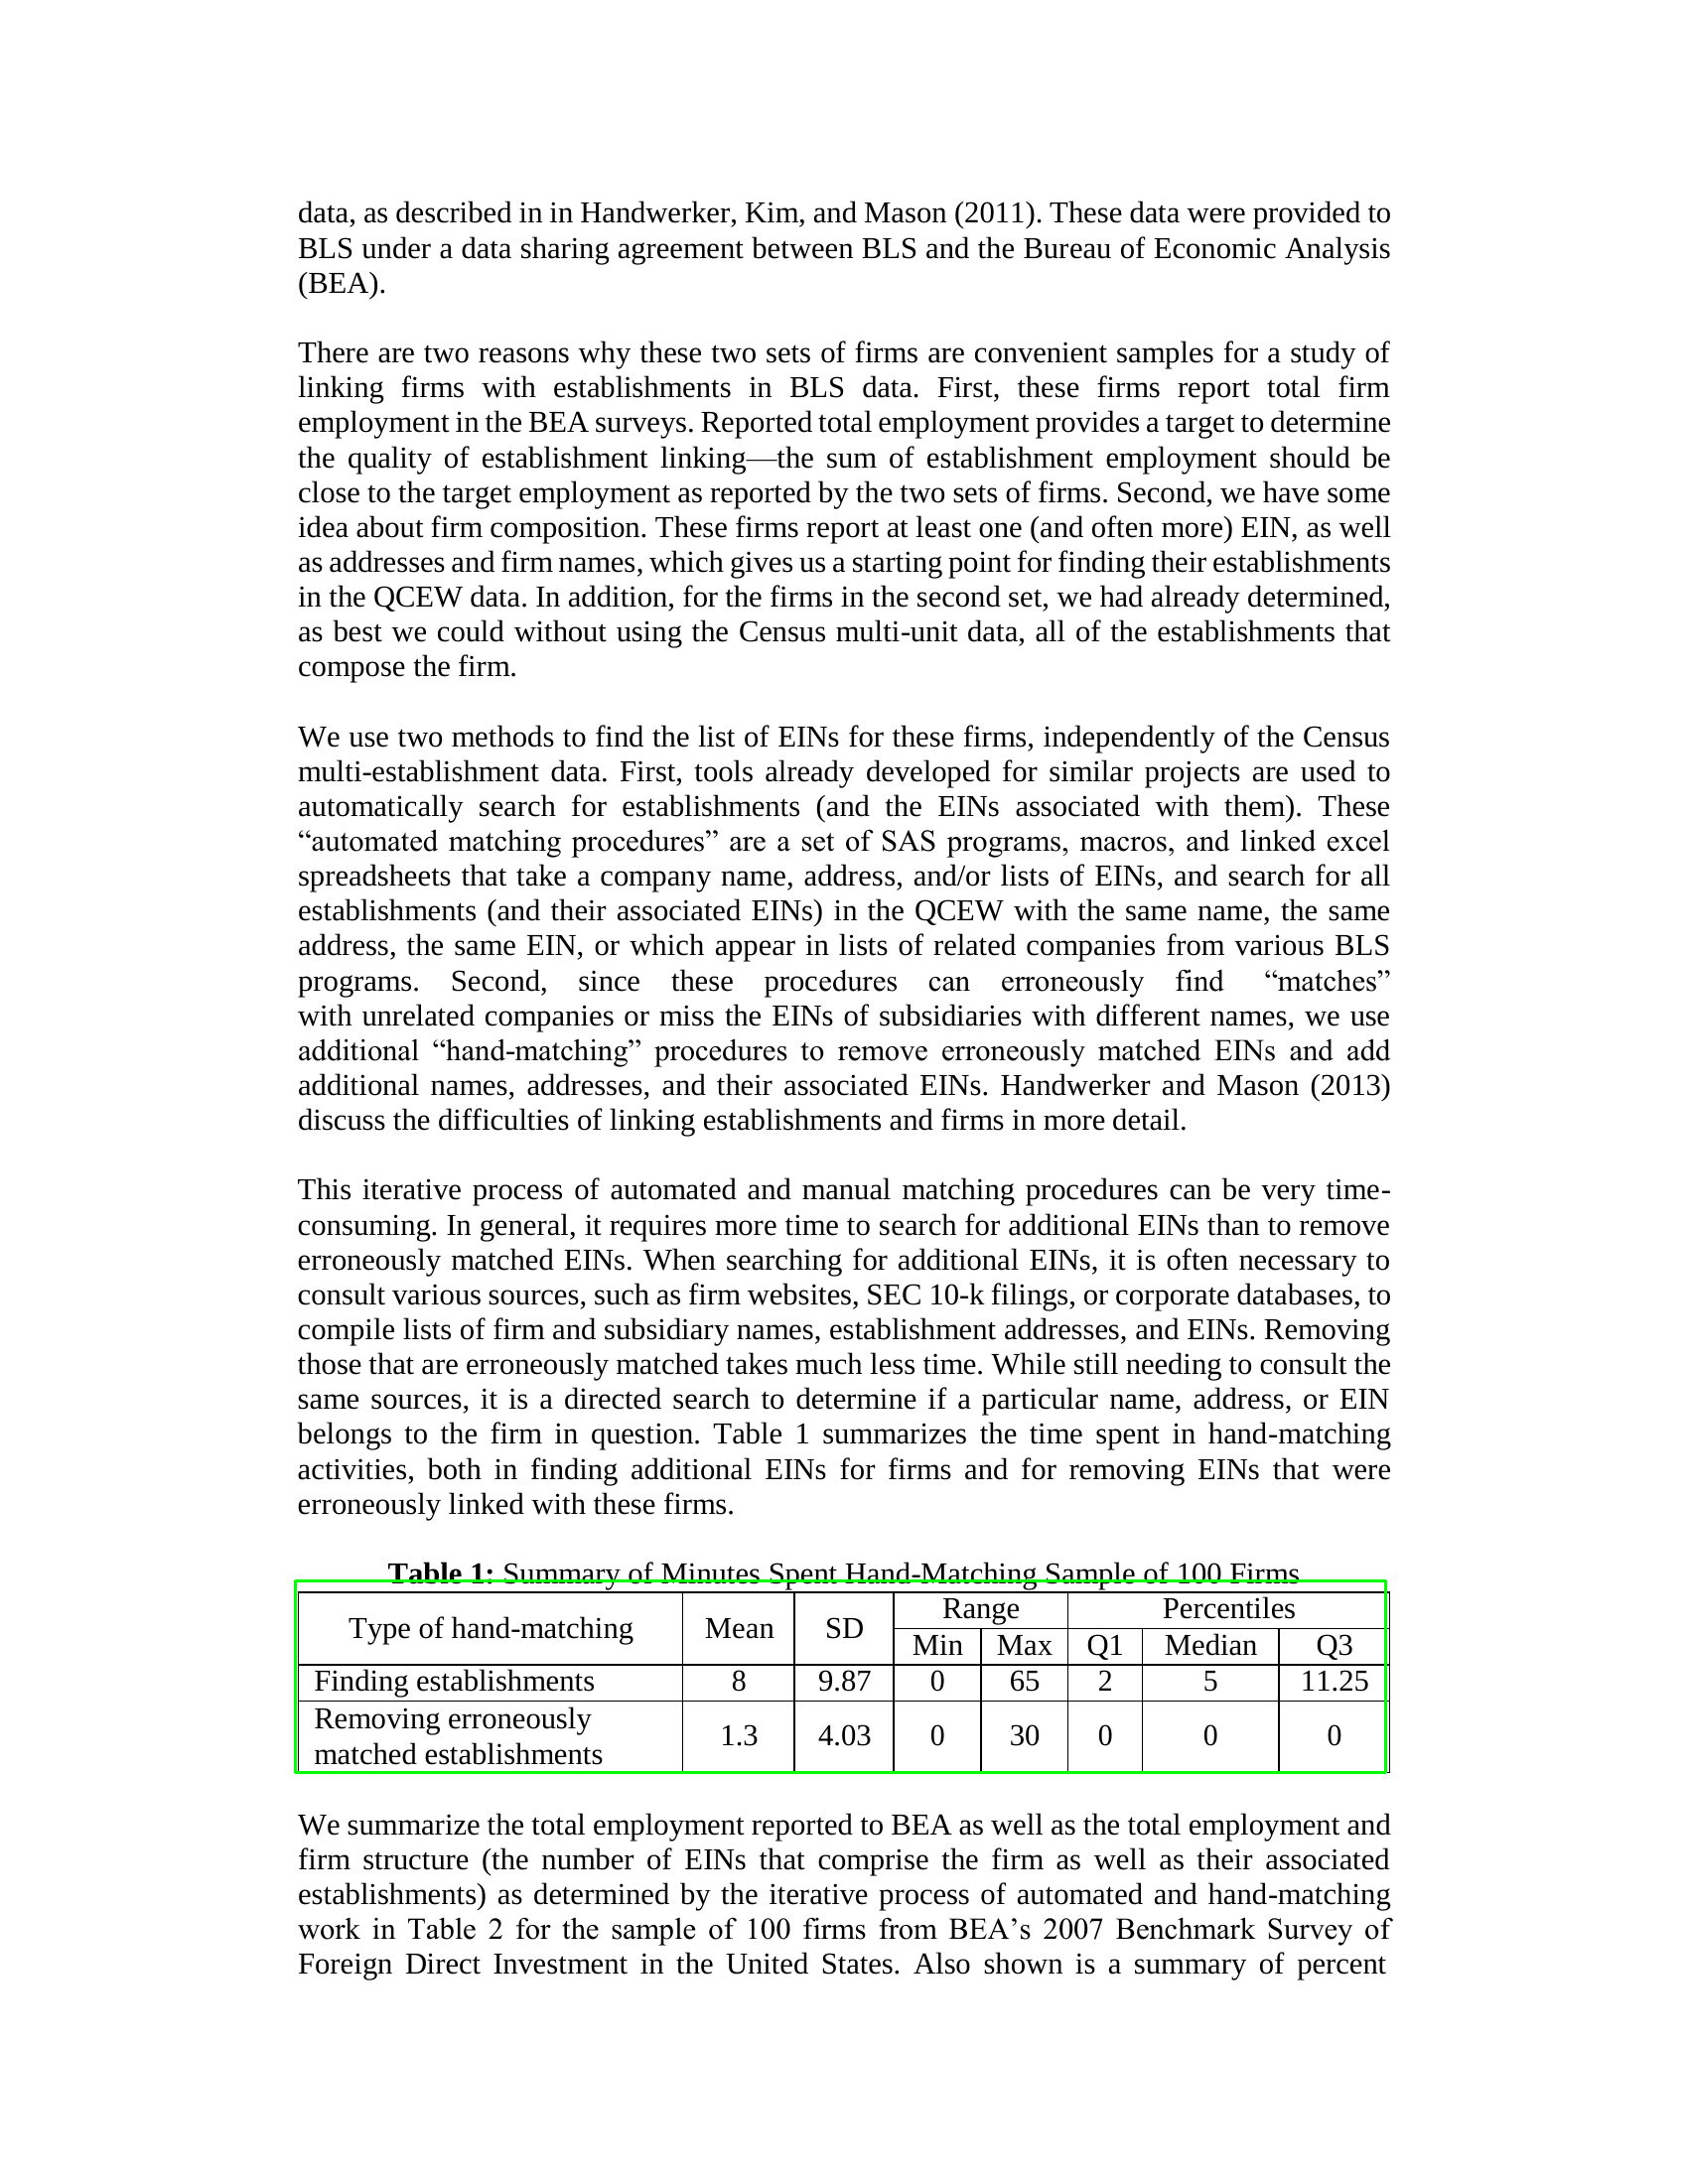

output_page_5.png 1 0.499508 0.240746 0.64542 0.184216

Name is:  1 output_page_5.png


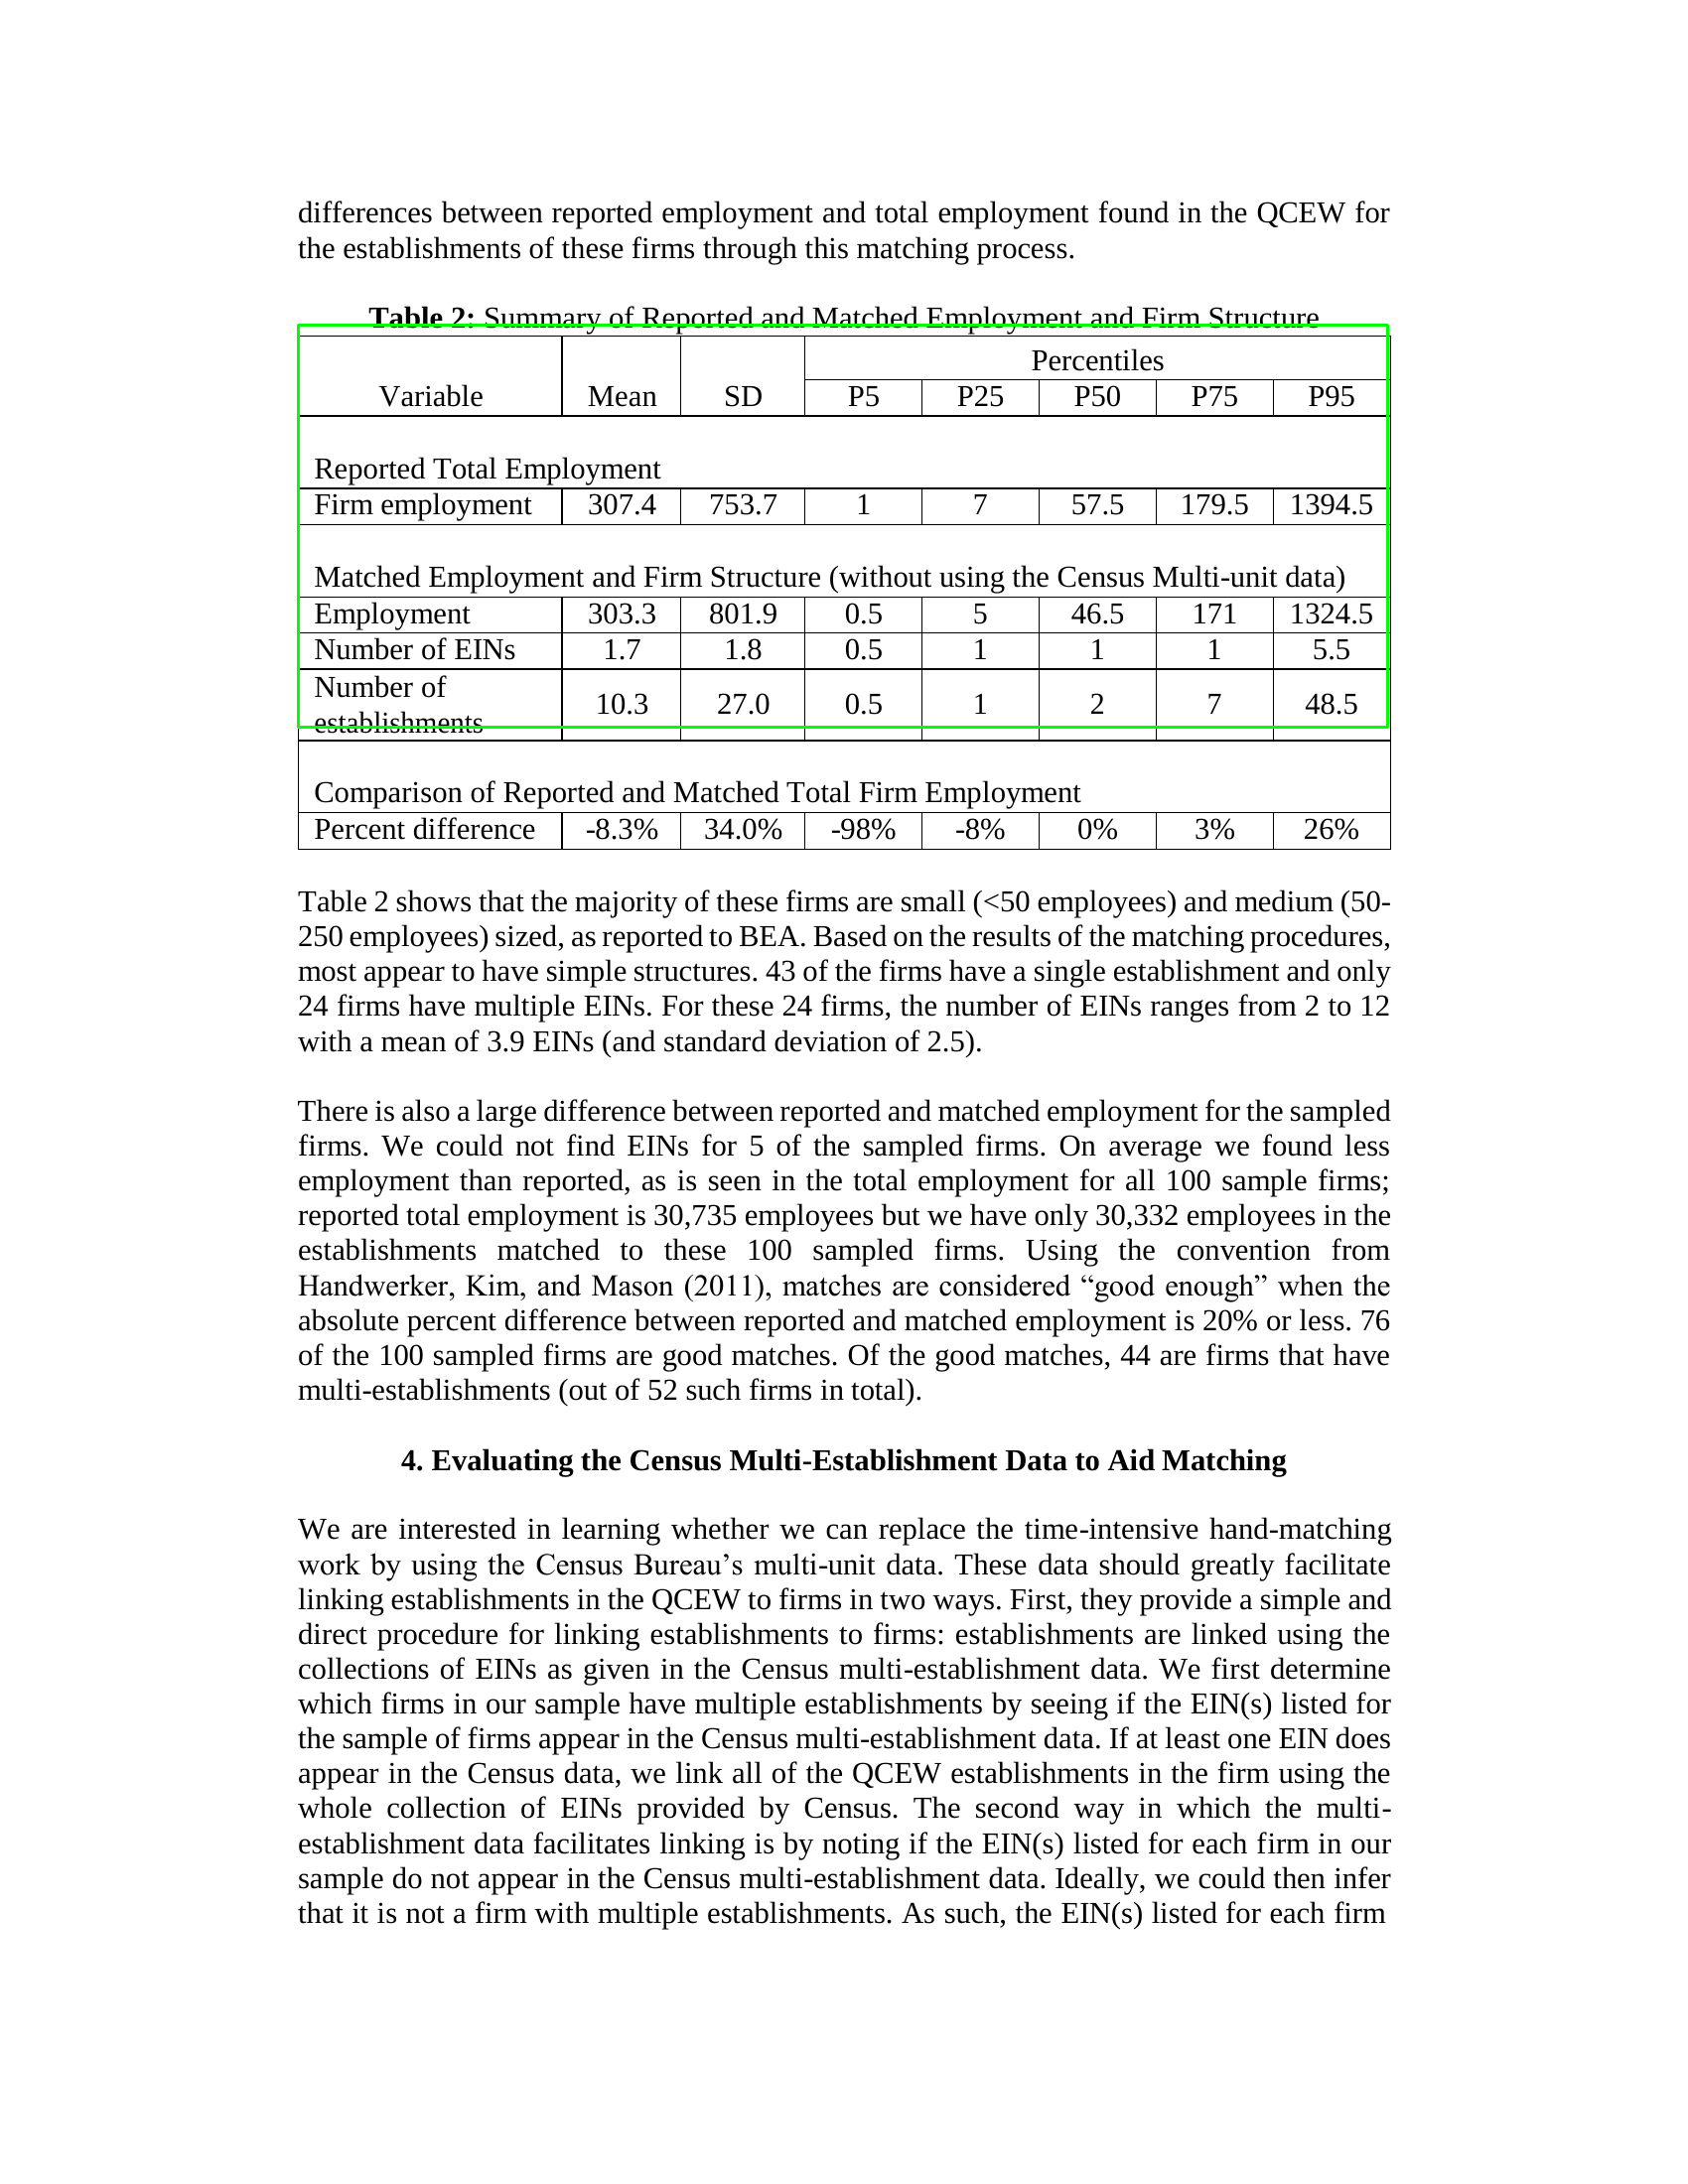

output_page_6.png 1 0.499833 0.328019 0.64716 0.102913

output_page_6.png 1 0.506315 0.728177 0.662595 0.235299

Name is:  2 output_page_6.png


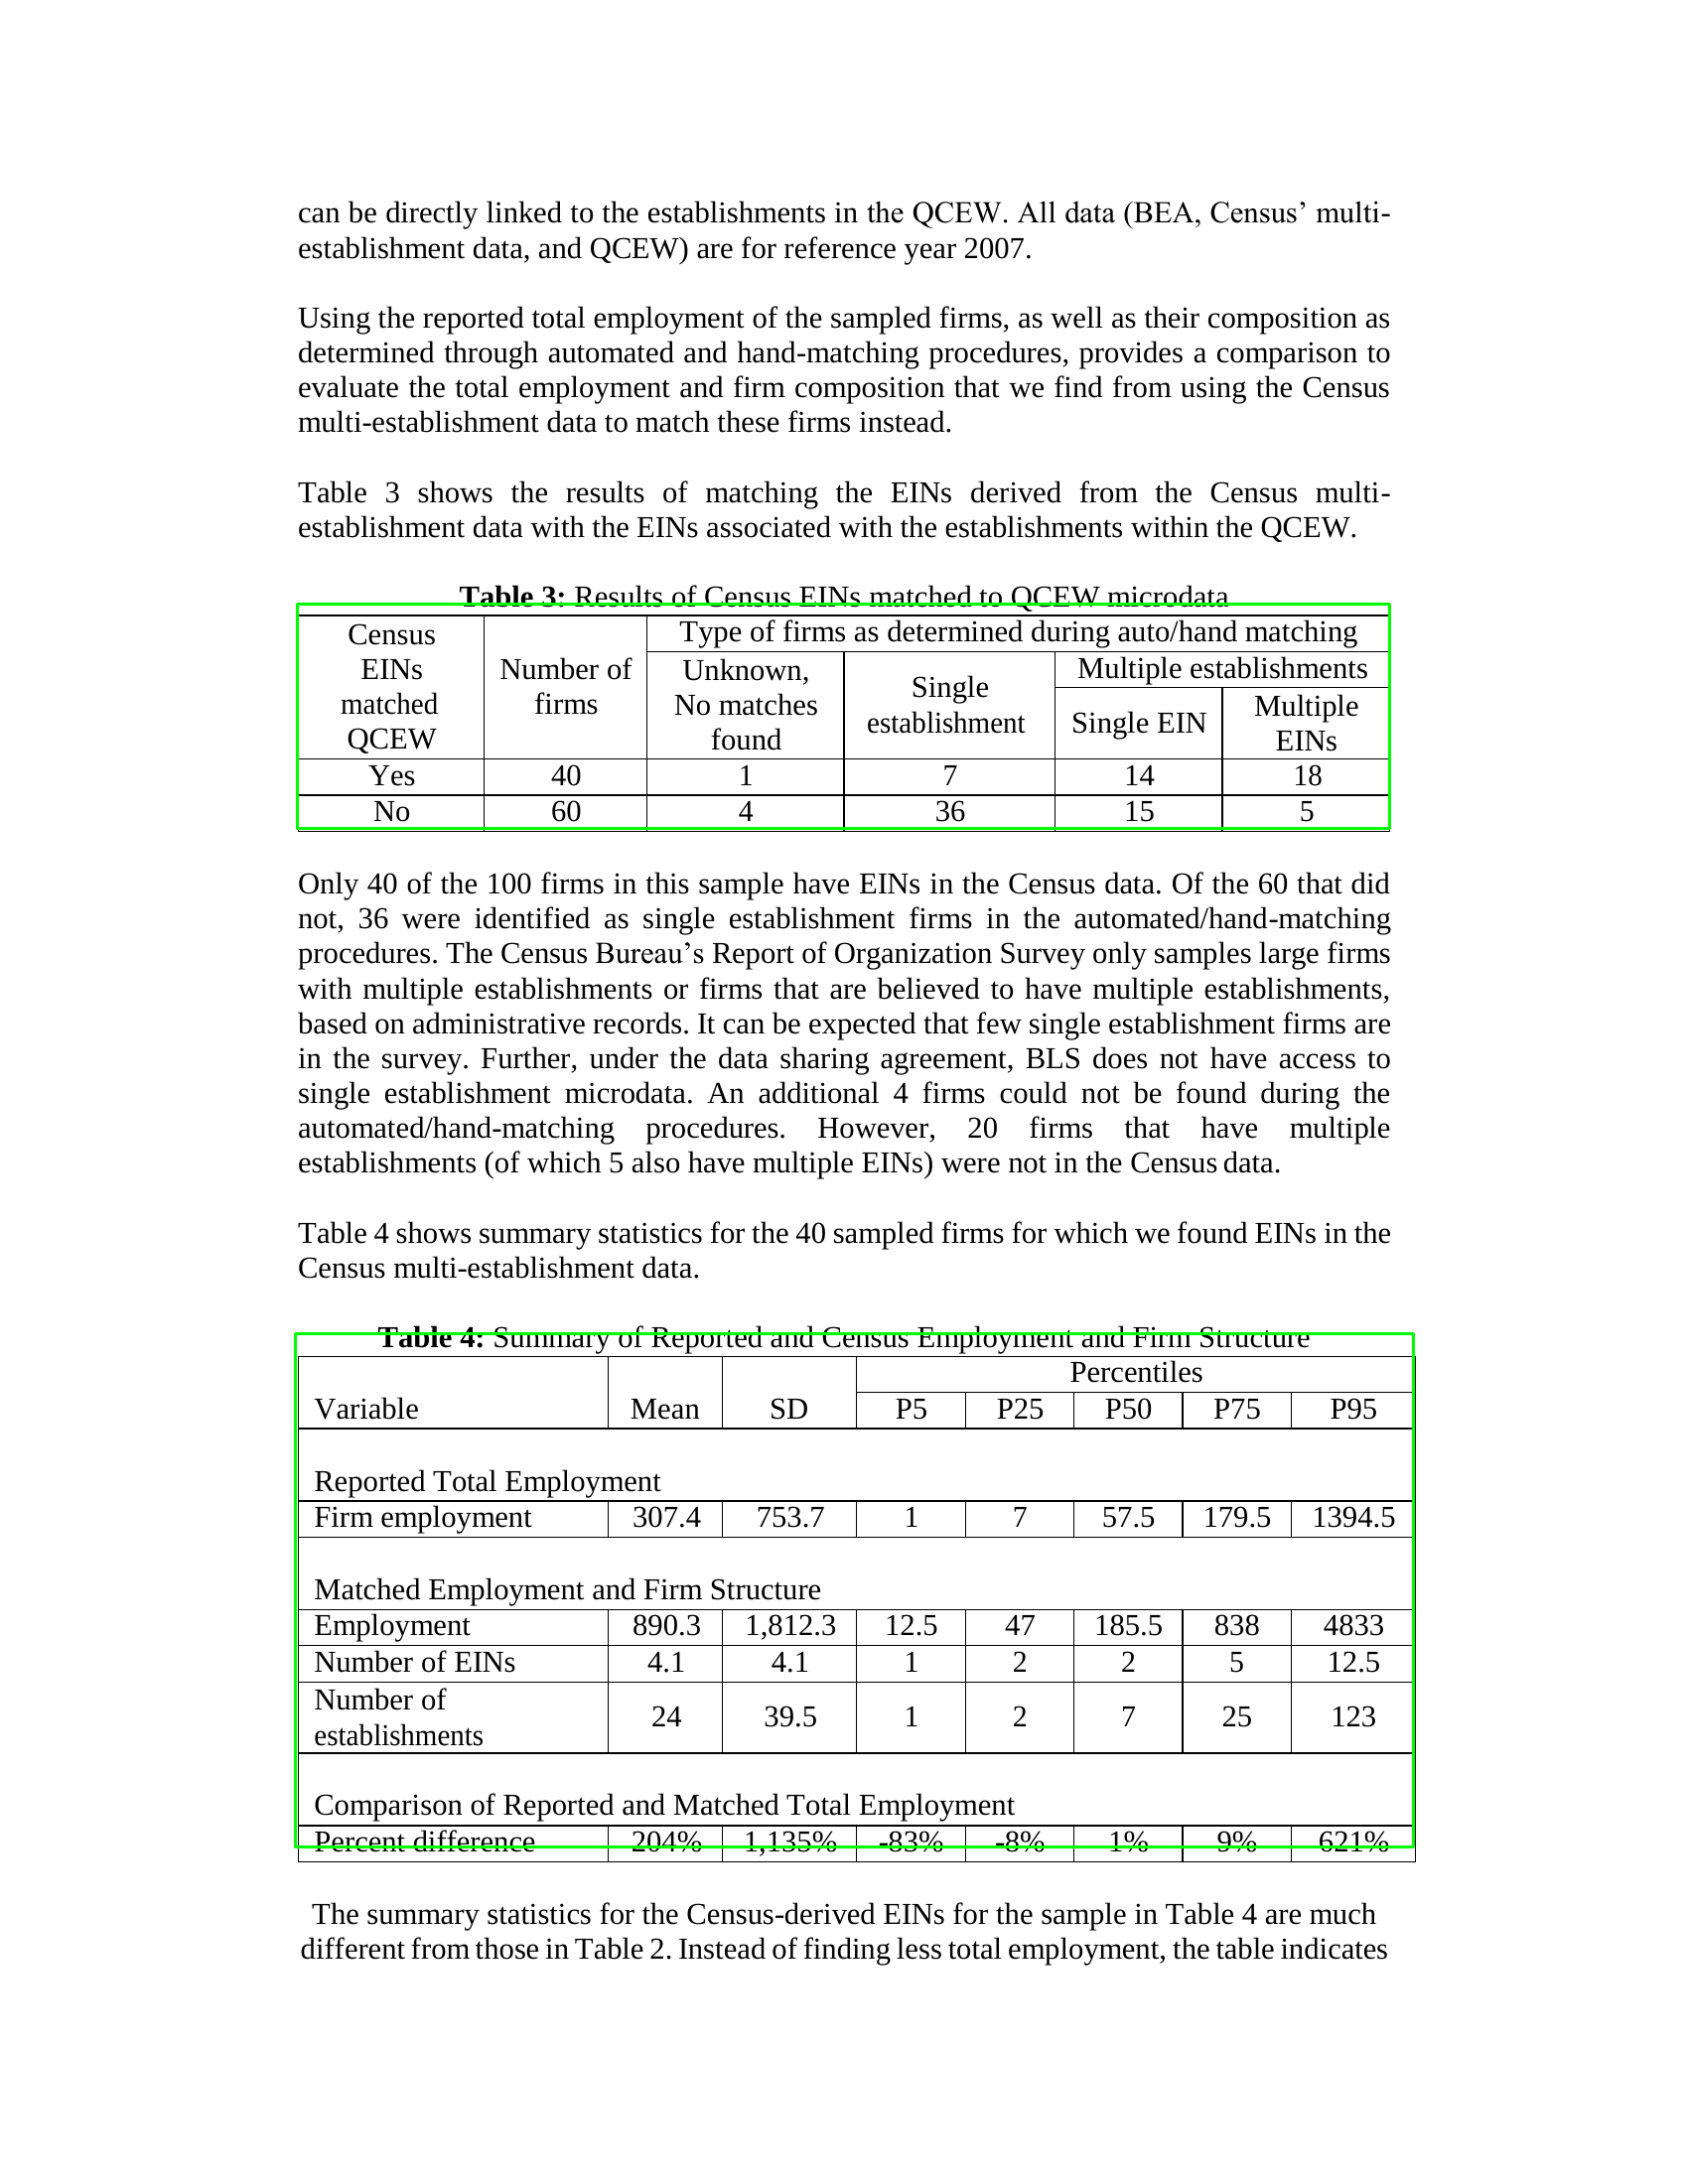

output_page_7.png 1 0.502882 0.357009 0.650774 0.101709

Name is:  3 output_page_7.png


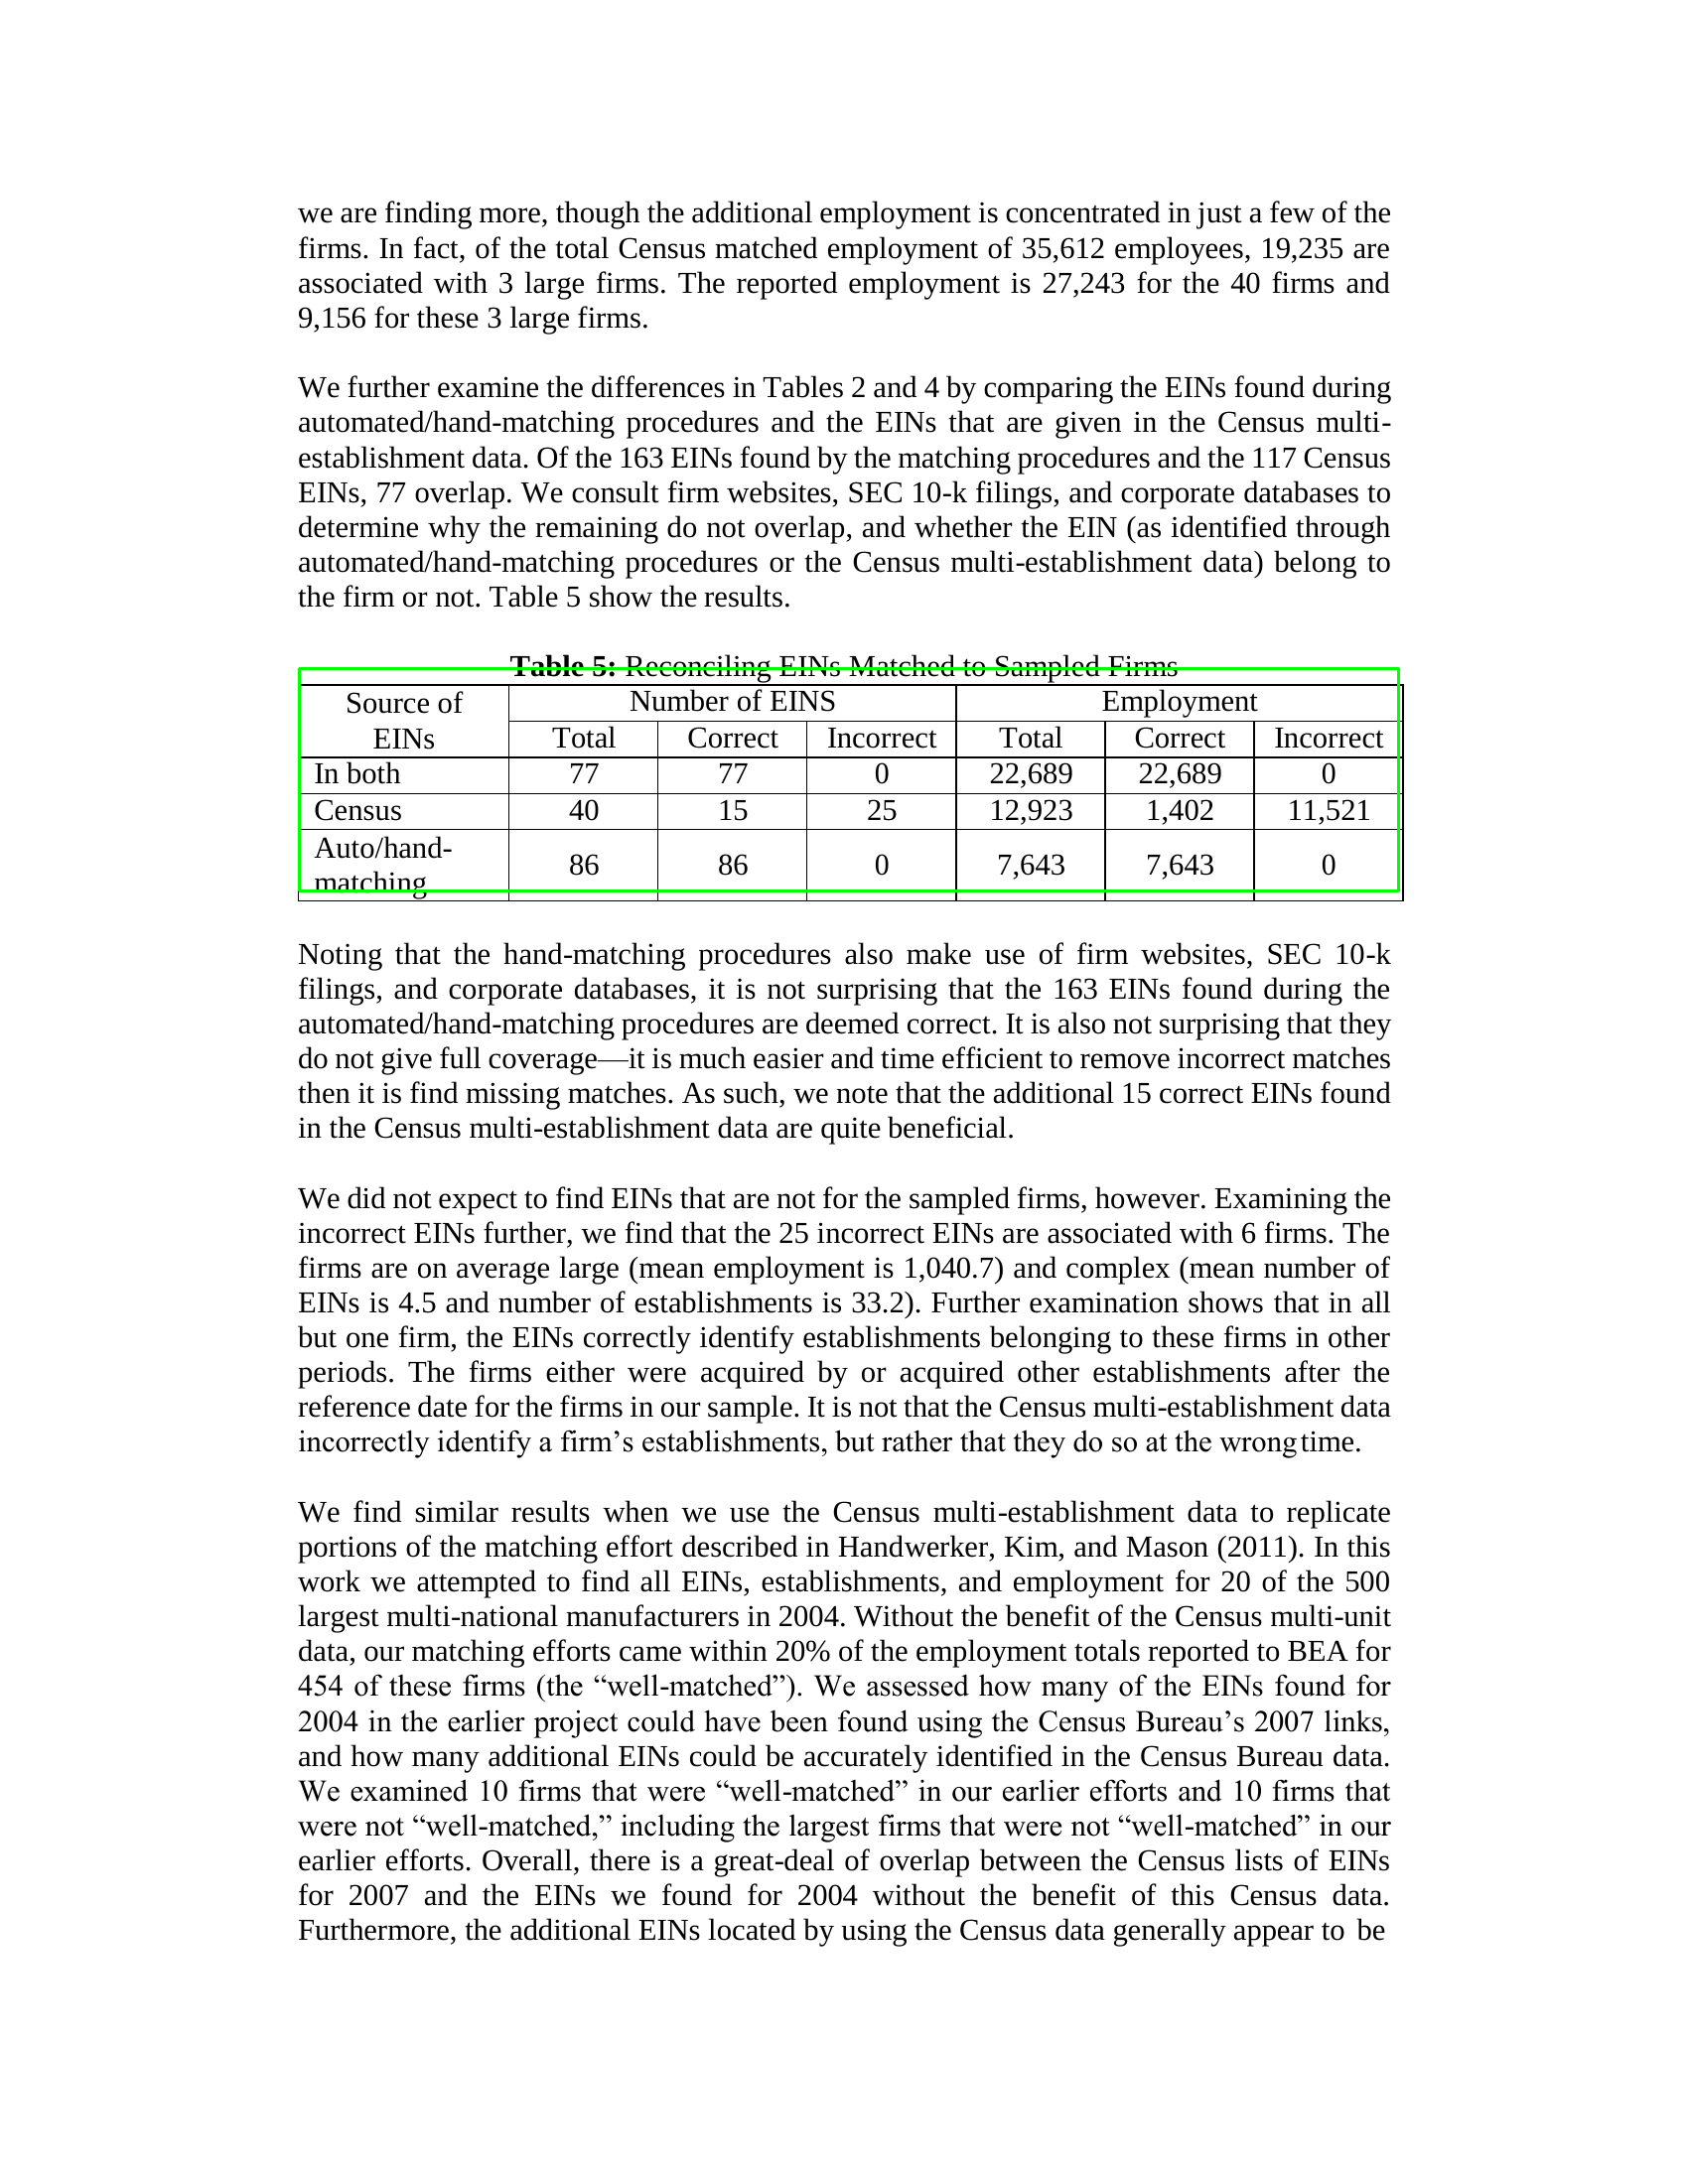

Annotation and display completed.


In [53]:
import cv2
import os
from IPython.display import Image, display

# Mount Google Drive to access your data (optional, if your data is in Google Drive)
from google.colab import drive
drive.mount('/content/drive')
#os.rmdir("/content/drive/MyDrive/yolov7/document-parts-2/Annotated")
#os.mkdir("/content/drive/MyDrive/yolov7/document-parts-2/Annotated")
# Directory containing images and label files
anno_dir =train_data + "/Annotated"
data_dir = output_dir_
data_dir_labels =  inf_dir + "labels"
file_list = os.listdir(data_dir)
print(file_list)


# Counter to limit the number of images displayed
display_count = 0


print("total number of images in this directory is :", len(file_list))


# Loop through each image in the directory
for image_file in file_list:
    if image_file.endswith(".png"):  # Adjust the file extension as needed
        # Load the image
        image_path = os.path.join(data_dir, image_file)
        image = cv2.imread(image_path)

        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(data_dir_labels, label_file)

        # Read label annotations from the YOLO format file
        if os.path.exists(label_path) and os.stat(label_path).st_size > 0:
          with open(label_path, "r") as label_file:
            lines = label_file.readlines()

          for line in lines:
            print(image_file, line)
            # Parse the YOLO annotation (x_center, y_center, width, height)
            class_id, x_center, y_center, width, height = map(float, line.strip().split())

            # Convert YOLO coordinates to OpenCV coordinates
            x1 = int((x_center - width / 2) * image.shape[1])
            y1 = int((y_center - height / 2) * image.shape[0])
            x2 = int((x_center + width / 2) * image.shape[1])
            y2 = int((y_center + height / 2) * image.shape[0])

            # Draw a bounding box on the image
            color = (0, 255, 0)  # Green color (BGR format)
            thickness = 2  # Line thickness
            image = cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

          # Save the annotated image within Google Colab
          output_image_file = os.path.join(anno_dir, "annotated_" + image_file)
          cv2.imwrite(output_image_file, image)

          # Display the annotated image using IPython
          print("Name is: ",display_count,image_file )
          display(Image(output_image_file))

          # Increment the counter
          display_count += 1

          # Check if we've displayed 100 images
          #if display_count >= 100:
           #   break  # Stop displaying images

# Print a message when the task is completed
print("Annotation and display completed.")


In [42]:
## for one image only


import cv2
import pytesseract
from PIL import Image

# Load the image with tables
image_path = "/content/drive/MyDrive/yolov8/Pdf_document/Pdf_To_Images/AutomateDocument/detect/TagTable/output_page_5_table_1.jpg"
# 'Pdf_To_Images/TagTable/output_page_12_table_1.jpg'
image = cv2.imread(image_path)
pil_image = Image.fromarray(image)

# Convert the image to grayscale for better OCR accuracy
#gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use pytesseract to perform OCR on the grayscale image
#ocr_result = pytesseract.image_to_string(gray_image)
ocr_result = pytesseract.image_to_string(image)

# Split the OCR result into lines
lines = ocr_result.split('\n')

# Initialize an empty matrix to store the table data
table_matrix = []

# Iterate through the lines to extract and construct the matrix
for line in lines:
    # Split each line by tab or space, depending on your table's formatting
    cells = line.split('\t')  # You can also try ' ' or other delimiters
    cleaned_cells = [cell.strip() for cell in cells if cell.strip()]  # Remove empty cells

    if cleaned_cells:
        table_matrix.append(cleaned_cells)

# Print the extracted matrix
for row in table_matrix:
    print(row)


['iable 2: summary of Keported and Matched Employment and rirm otructure']
['Percentiles']
['Variable Mean sD PS P25 P50 P75 P95']
['Reported Total Employment']
['Firm employment 307.4 753.7 1 7 57.5 179.5 | 1394.5']
['Matched Employment and Firm Structure (without using the Census Multi-unit data)']
['Employment 303.3 | 801.9 0.5 5 46.5 171 | 1324.5']
['Number of EINs 17 1.8 0.5 1 1 1 5.5']
['Number of 103 | 27.0 | 05 1 2 7 | 485']
['establishments']
